In [1]:
import pathlib

import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import h5py
from tqdm.auto import tqdm

import gala.dynamics as gd

import sys
if '../scripts' not in sys.path:
    sys.path.append('../scripts')
from streamsubhalosim import get_in_stream_frame, get_stream_track
from streamsubhaloplot import plot_sky_projections

# Load simulation metadata / summary file:

In [2]:
meta_path = pathlib.Path("../cache/dist-20kpc-gallery/stream-sims-metadata.fits")
allpars = at.QTable.read(meta_path)

In [3]:
fid_pars = allpars[0]
fid_pars

id,M_subhalo,dens_fac,c_subhalo,impact_b_fac,impact_b,phi,vphi,vz,t_post_impact,filename
,solMass,,kpc,,kpc,deg,pc / Myr,pc / Myr,Myr,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes104
0,3162277.6601683795,1.0,0.17871708070891174,1.0,0.17871708070891174,0.0,63.999999999999986,0.0,200.00000000000003,/mnt/ceph/users/apricewhelan/projects/dark-sectors-mw/cache/dist-20kpc-gallery/sims/stream-sim-0000.hdf5


# Load unperturbed stream:

In [4]:
with h5py.File("../cache/dist-20kpc-gallery/sims/stream-sim-init.hdf5", mode="r") as f:
    init_stream = gd.PhaseSpacePosition.from_hdf5(f["stream"])
    init_prog = gd.PhaseSpacePosition.from_hdf5(f["prog"])
    impact = gd.PhaseSpacePosition.from_hdf5(f["impact_site"])

In [5]:
init_stream_sfr = get_in_stream_frame(init_stream, prog=init_prog, impact=impact)
stream_frame = init_stream_sfr.replicate_without_data()
tracks = get_stream_track(init_stream_sfr, lon_lim=(-45, 45))

# Load models for components of gallery

In [6]:
K = 5
gallery_pars = ['M_subhalo', 'dens_fac', 'impact_b_fac', 'vphi', 't_post_impact']
all_par_names = gallery_pars + ['vz', 'phi']
M = len(gallery_pars)

unique_vals = {k: np.unique(allpars[k]) for k in gallery_pars}
for k, v in unique_vals.items():
    assert len(v) == K
unique_vals

{'M_subhalo': <Quantity [  316227.76601684,  1000000.        ,  3162277.66016838,
            10000000.        , 31622776.60168379] solMass>,
 'dens_fac': <Column name='dens_fac' dtype='float64' length=5>
               0.25
                0.5
                1.0
 1.9999999999999998
                4.0,
 'impact_b_fac': <Column name='impact_b_fac' dtype='float64' length=5>
 0.0
 0.5
 1.0
 2.0
 4.0,
 'vphi': <Quantity [ 16.,  32.,  64., 128., 256.] pc / Myr>,
 't_post_impact': <Quantity [ 50., 100., 200., 400., 800.] Myr>}

# Plot fiducial stream

(<Figure size 1152x1440 with 5 Axes>,
 array([<Axes: ylabel='phi2'>, <Axes: ylabel='distance'>,
        <Axes: ylabel='pm_phi1_cosphi2'>, <Axes: ylabel='pm_phi2'>,
        <Axes: xlabel='stream longitude $\\phi_1$ [deg]', ylabel='radial_velocity'>],
       dtype=object))

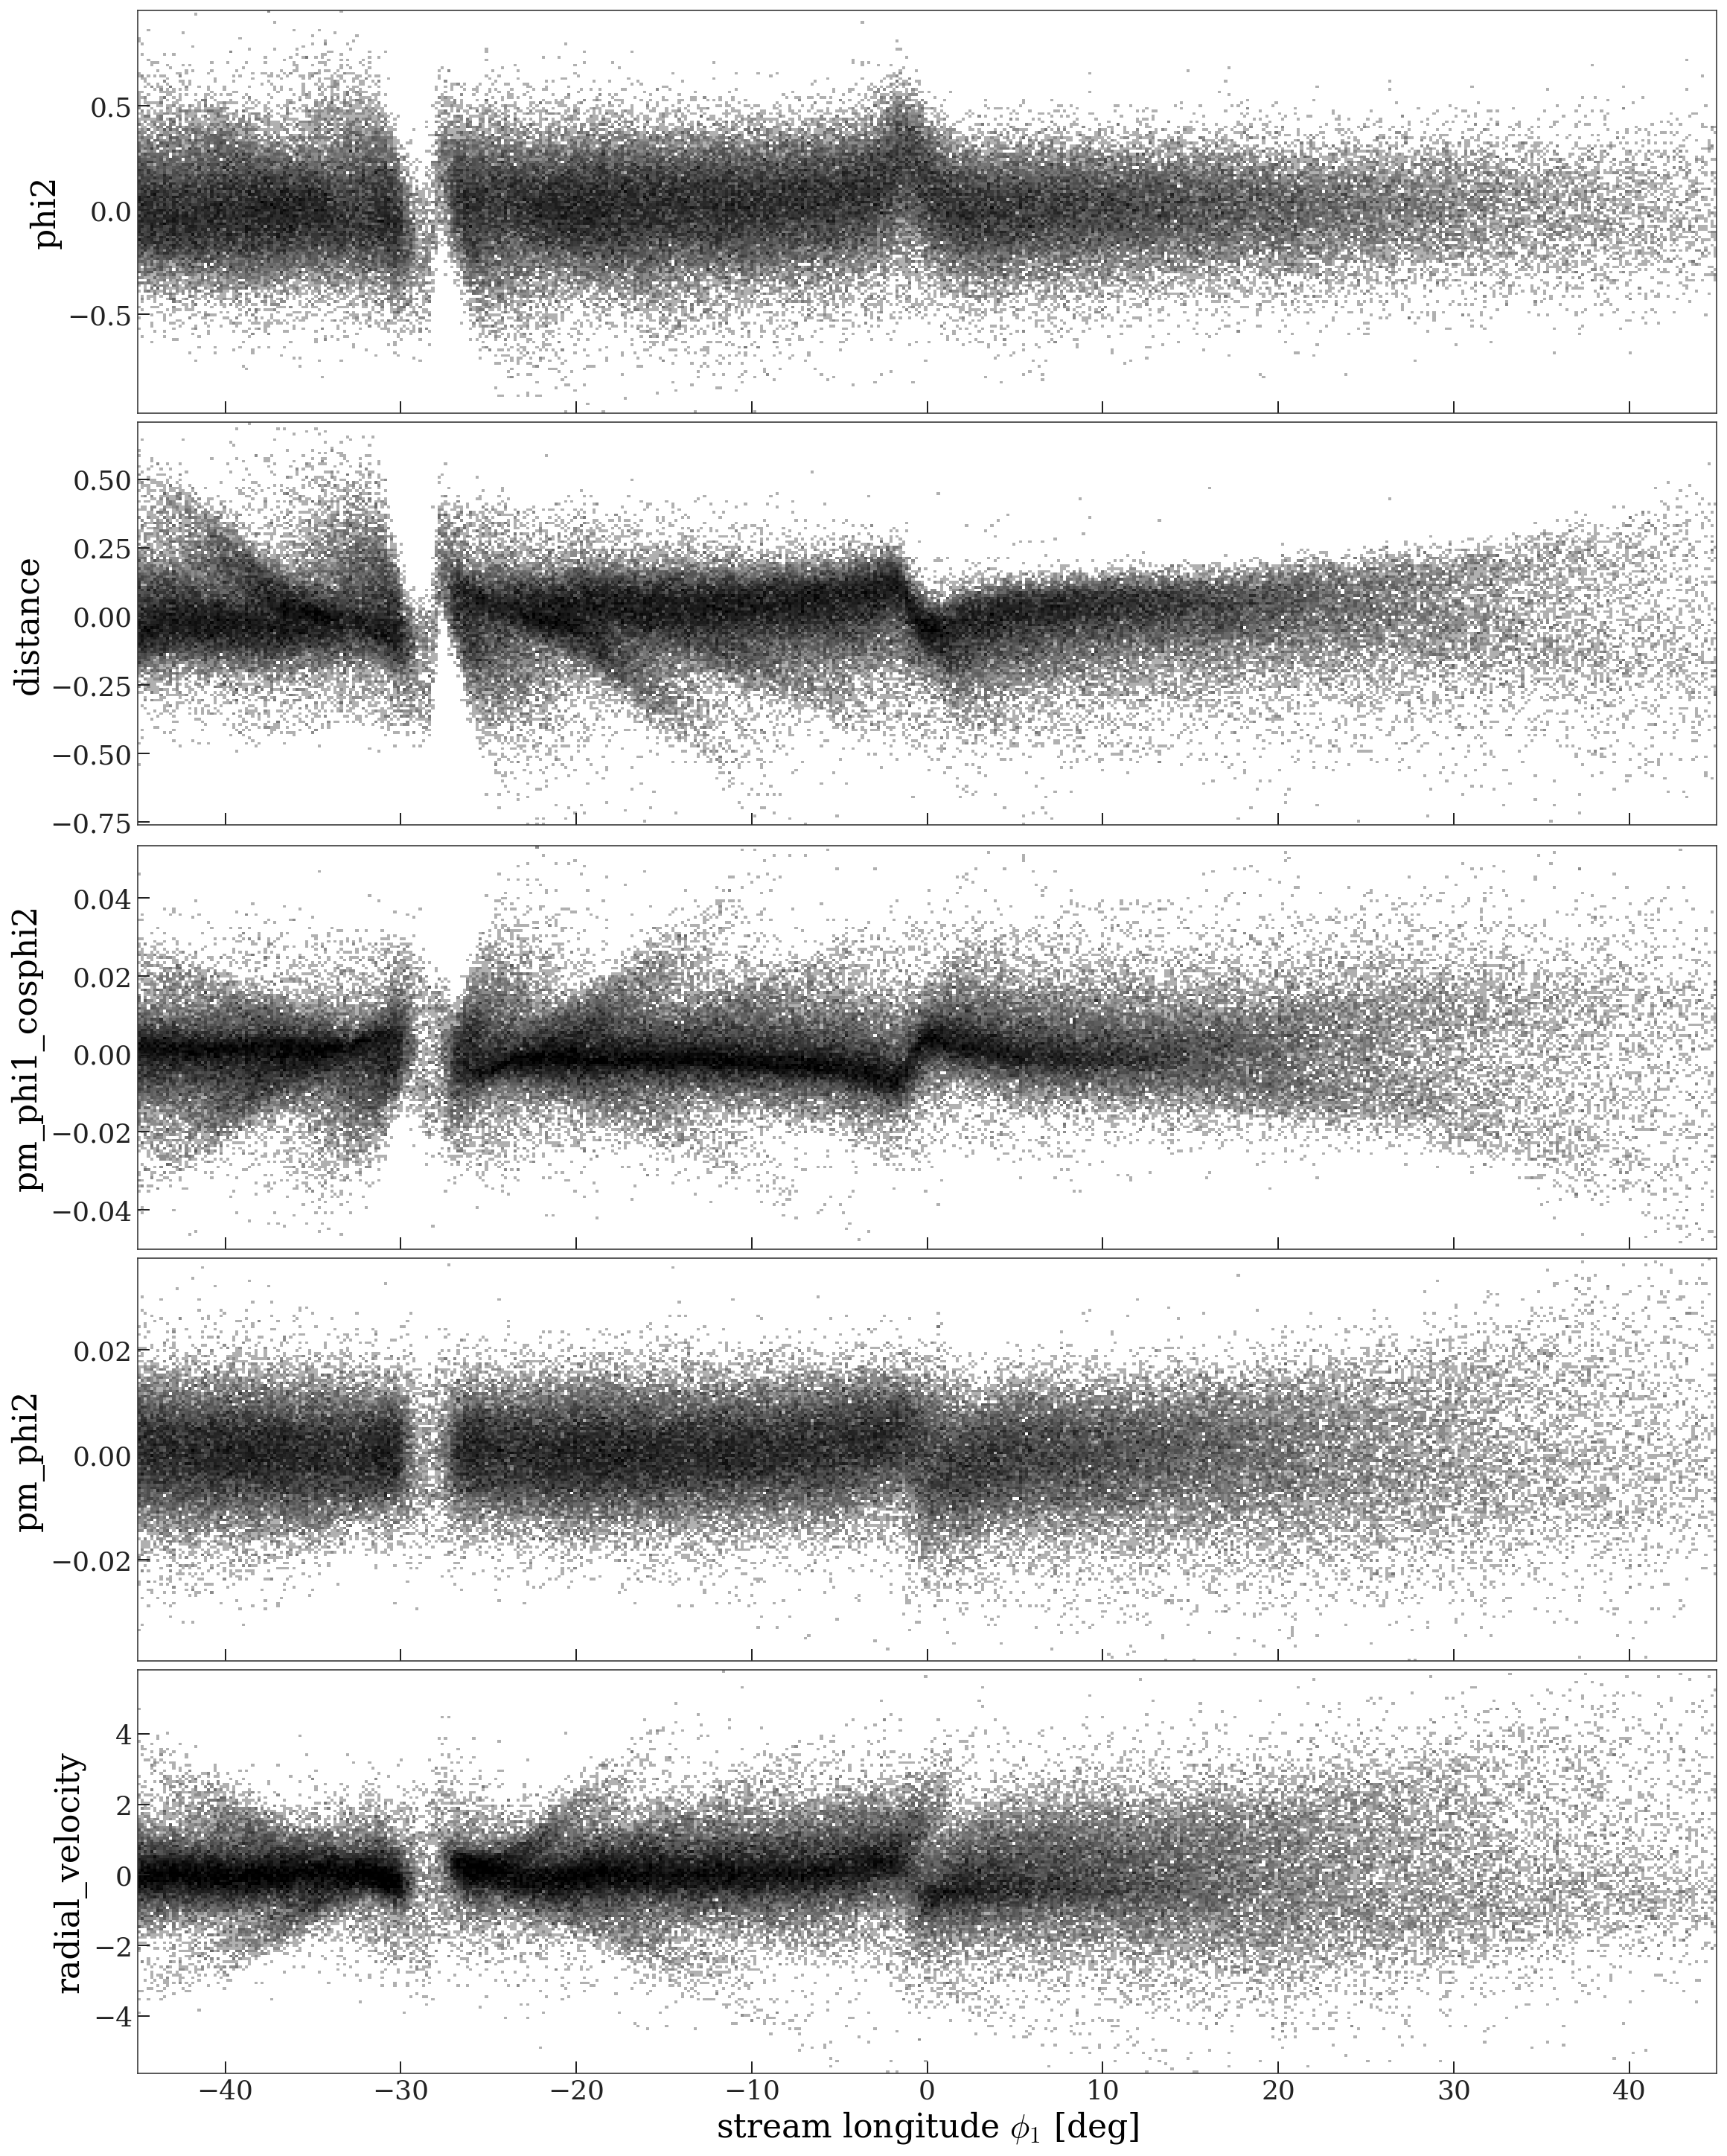

In [7]:
and_args = [np.isclose(allpars[par], fid_pars[par]) for par in all_par_names]
(row_i,) = np.where(np.logical_and.reduce(and_args))[0]
row = allpars[row_i]

with h5py.File(row["filename"], mode="r") as f:
    stream = gd.PhaseSpacePosition.from_hdf5(f["stream"])
    stream_sfr = stream.to_coord_frame(stream_frame)
plot_sky_projections(
    stream_sfr,
    tracks=tracks,
    annotate_impact=False,
    xlim=(-45, 45),
)

In [32]:
par_to_label = {
    "M_subhalo": r"M_{\bullet}",
    "dens_fac": r"f_{\rho}",
    "impact_b_fac": r"f_b",
    "vphi": r"v_{\phi}",
    "t_post_impact": r"\delta t"
}

par_to_desc = {
    "M_subhalo": "subhalo mass",
    "dens_fac": "subhalo density\n enhancement factor",
    "impact_b_fac": "impact parameter\n(units of scale radius)",
    "vphi": "velocity perpendicular\n to stream",
    "t_post_impact": "time since impact"
}

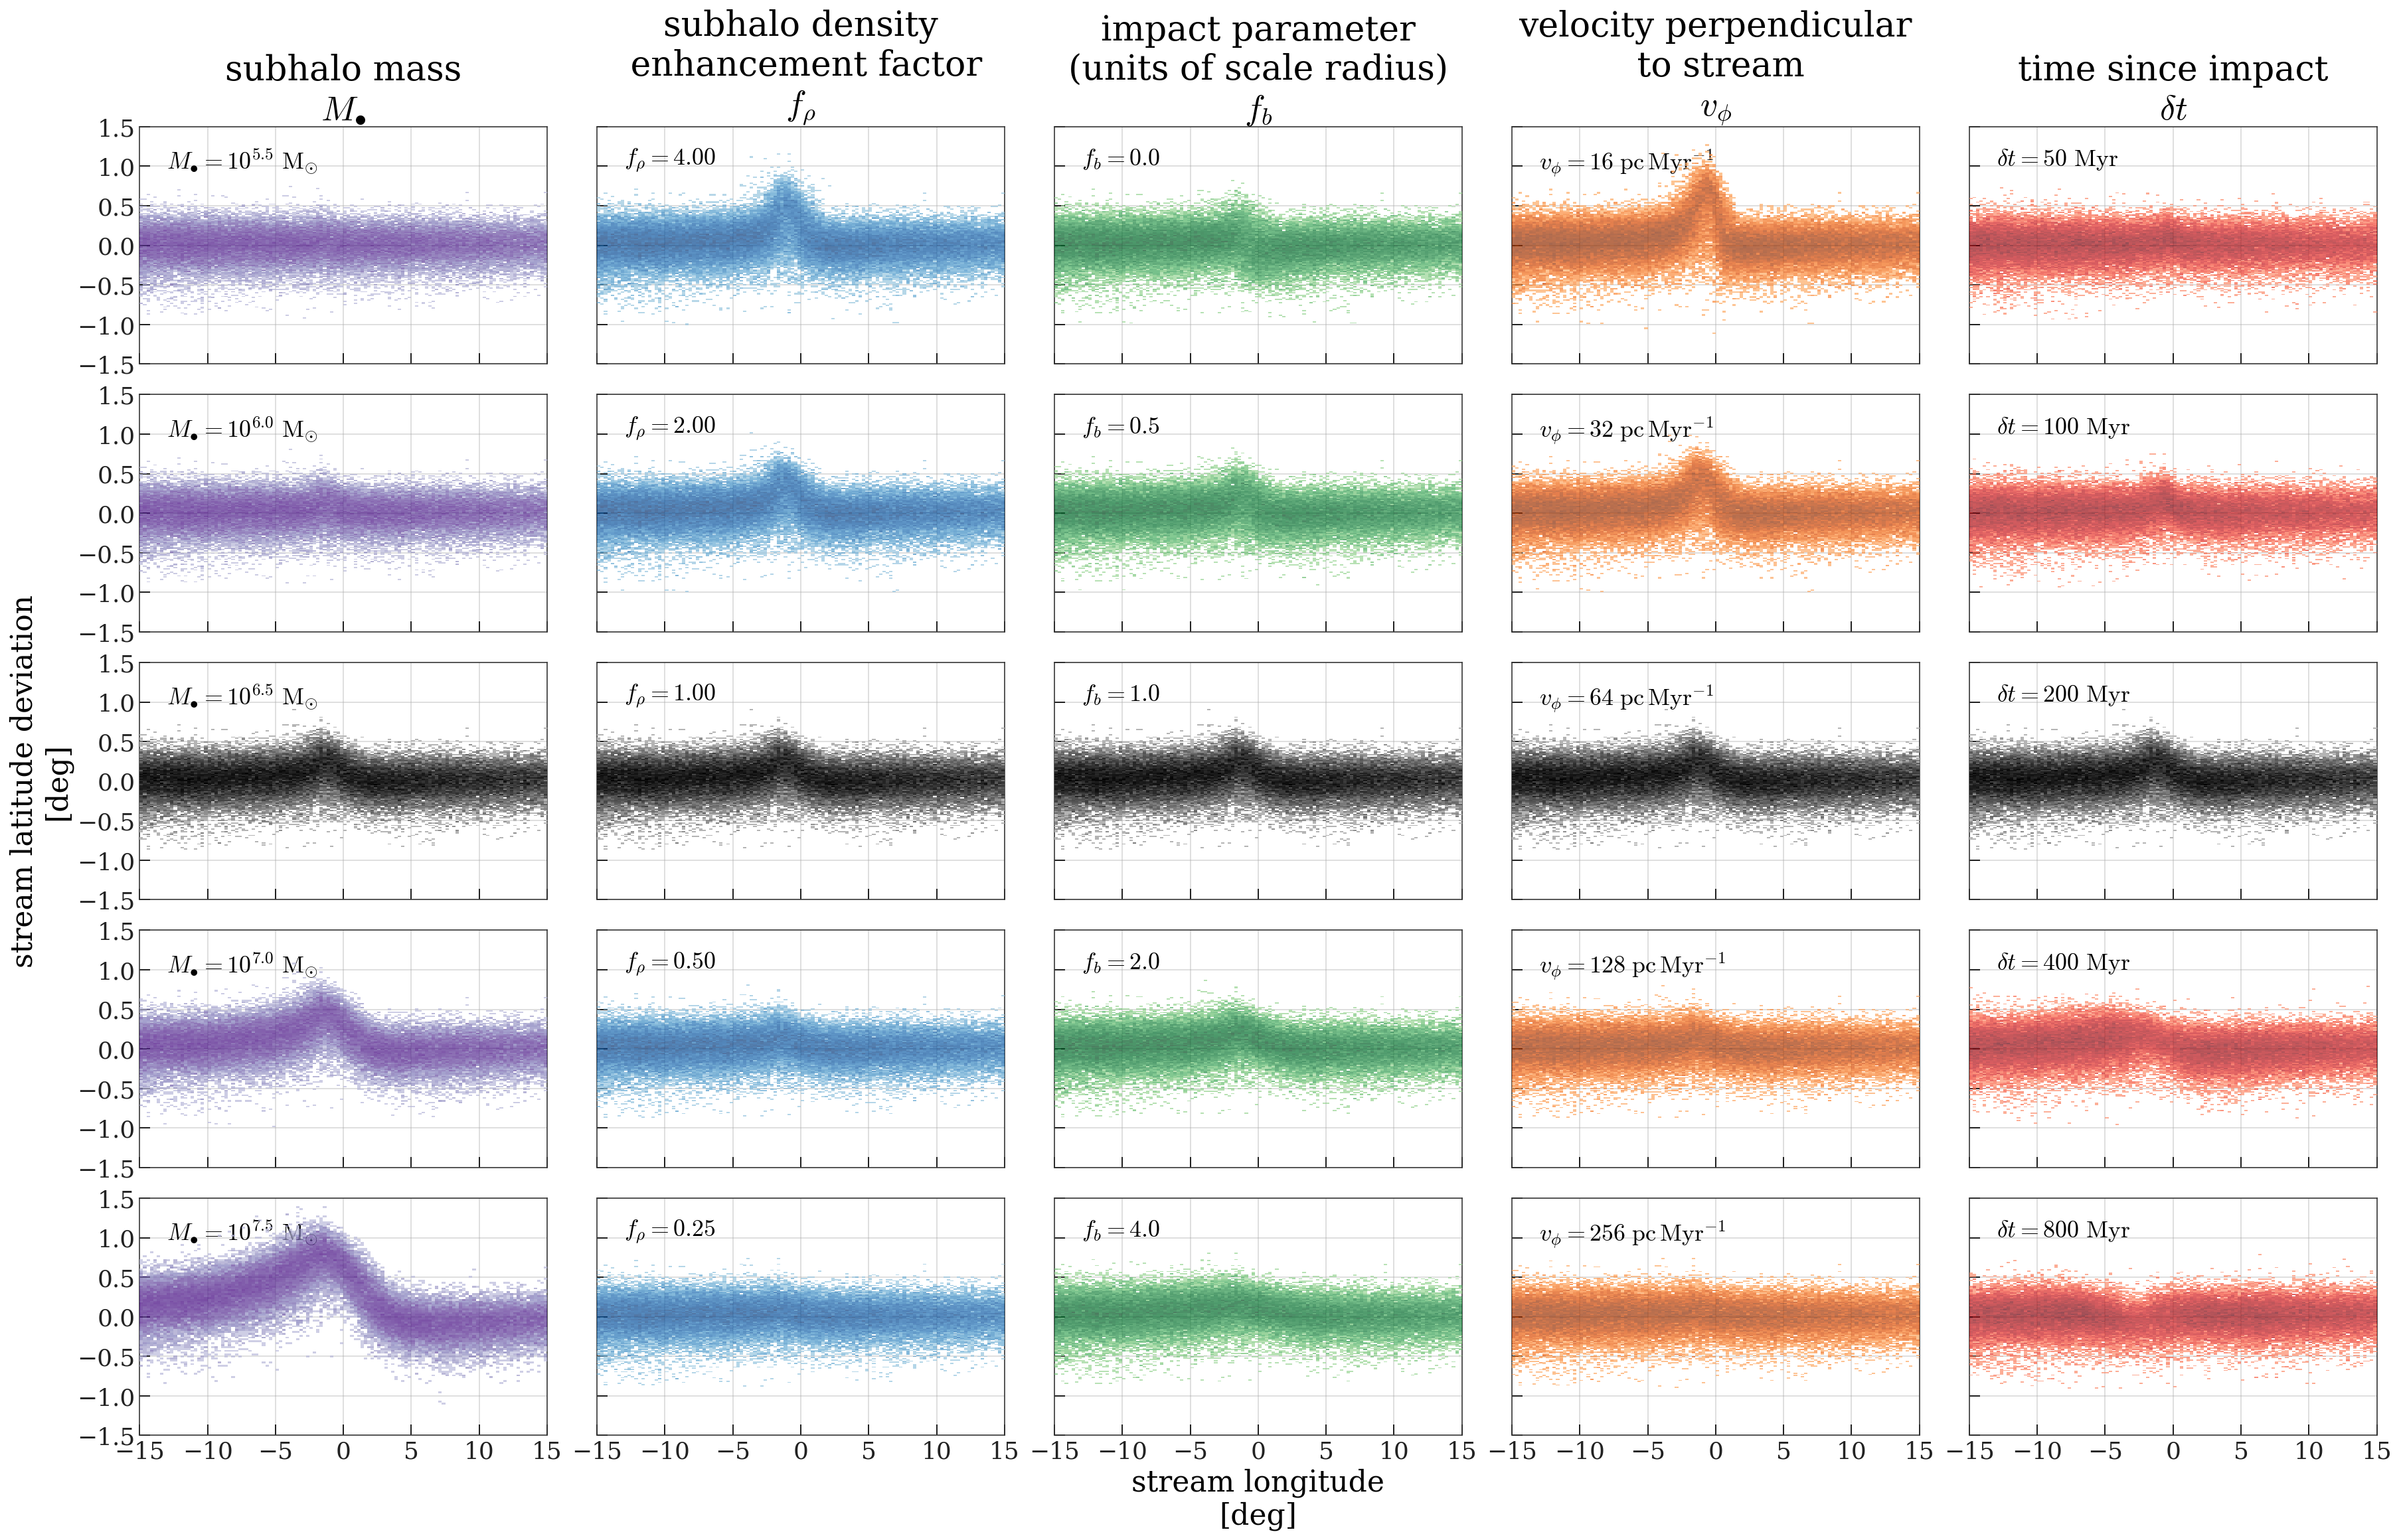

In [43]:
component = "phi2"
ylabel = "stream latitude deviation\n" + f"[deg]"
ylim = (-1.5, 1.5)
yticks = np.arange(-1.5, 1.5 + 1e-3, 0.5)

# component = "pm_phi1_cosphi2"
# ylabel = "stream proper motion deviation\n" + f"[{u.mas/u.yr:latex_inline}]"
# ylim = (-0.07, 0.07)
# yticks = np.arange(-0.06, 0.06 + 1e-3, 0.02)

# component = "radial_velocity"
# ylabel = "radial velocity deviation\n" + f"[{u.km/u.s:latex_inline}]"
# ylim = (-7, 7)
# yticks = np.arange(-6, 6 + 1, 2)

# ---

cmaps = ["Purples", "Blues", "Greens", "Oranges", "Reds"]

fig, axes = plt.subplots(
    K, M, figsize=(5 * M, 3 * K + 1), sharex=True, sharey=True, constrained_layout=True
)

for m, axcol in enumerate(axes.T):
    col_par = gallery_pars[m]

    axcol[0].set_title(f"{par_to_desc[col_par]}\n${par_to_label[col_par]}$")
    for k, ax in enumerate(axcol):
        if k == 2:
            cmap = "Greys"
            alpha = 1.0
        else:
            cmap = cmaps[m]
            alpha = 0.7

        and_args = [
            np.isclose(allpars[par], fid_pars[par])
            if par != gallery_pars[m]
            else np.isclose(allpars[par], unique_vals[par][k])
            for par in all_par_names
        ]
        (row_i,) = np.where(np.logical_and.reduce(and_args))[0]
        row = allpars[row_i]

        with h5py.File(row["filename"], mode="r") as f:
            stream = gd.PhaseSpacePosition.from_hdf5(f["stream"])
        stream_sfr = stream.to_coord_frame(stream_frame)
        plot_sky_projections(
            stream_sfr,
            tracks=tracks,
            components=[component],
            axes=[ax],
            annotate_impact=False,
            xlim=(-15, 15),
            hist2d_n_xbins=121,
            hist2d_n_ybins=121,
            xlabel=False,
            ylabel=False,
            hist2d_kwargs=dict(cmap=cmap, alpha=alpha, zorder=100, rasterized=True),
        )

        par_val = unique_vals[gallery_pars[m]][k]
        if col_par == "M_subhalo":
            val_str = (
                f"10^{{{np.log10(par_val.value):.1f}}}~"
                + (f"{u.Msun:latex_inline}")[1:-1]
            )
        elif col_par in ["vphi", "t_post_impact"]:
            val_str = f"{par_val.value:.0f}~" + (f"{par_val.unit:latex_inline}")[1:-1]
        elif col_par == "dens_fac":
            val_str = f"{1/par_val:.2f}"
        else:
            val_str = f"{par_val:.1f}"
        ax.text(
            -13,
            ylim[1] * 0.83,
            f"${par_to_label[col_par]} = {val_str}$",
            ha="left",
            va="top",
            fontsize=18,
        )

for ax in axes.flat:
    ax.grid(which="major", color="#aaaaaa", alpha=0.5, zorder=-100)

axes[2, 0].set_ylabel(ylabel)
axes[-1, 2].set_xlabel("stream longitude\n" + "[deg]")

ax.set(
    xlim=(-15, 15),
    ylim=ylim,
    xticks=np.arange(-15, 15 + 1, 5),
    yticks=yticks,
);

fig.savefig(f"../tex/figures/stream-gallery-{component}.pdf", dpi=250)